In [17]:
repo_directory = '/Users/iaincarmichael/Dropbox/Research/law/law-net/'
data_dir = '/Users/iaincarmichael/data/courtlistener/'

import os
import sys
import time
from math import *
import copy
import cPickle as pickle

# data
import numpy as np
import pandas as pd

# viz
import matplotlib.pyplot as plt


# graph
import igraph as ig


# our code
sys.path.append(repo_directory + 'code/')
from pipeline.download_data import *
from pipeline.make_raw_case_metadata import *
from helpful_functions import case_info

sys.path.append(repo_directory + 'vertex_metrics_experiment/code/')
from make_case_text_files import *
from custom_vertex_metrics import get_CiteRankPoly, get_CiteRank


# court
court = 'scotus'
network_name = 'scotus'

# directory set up
experiment_data_dir = data_dir + 'scotus/'
text_dir = experiment_data_dir + 'textfiles/'



# jupyter notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
G = ig.Graph.Read_GraphML(experiment_data_dir + 'scotus_network.graphml')

# recent degree

In [17]:
def get_vertex_recent_citations(v, threshold_year):
    return len([ing for ing in v.neighbors(mode="IN") if threshold_year <= ing['year']])

In [34]:
def get_recent_citations(G, current_year, threshold):
    """
    Number of citations in past T years
    
    Parameters
    ---------
    G: igraph object with 'year' vertex attributes
    
    current_year: current year
    
    threshold: how many years before to look
    
    Output
    ------
    Returns a list ordered by ig index of recent citations
    
    i.e. number citations that happend after current_year - threshold
    """
    threshold_year = current_year - threshold
    return [get_vertex_recent_citations(v, threshold_year) for v in G.vs]

In [9]:
rd = get_recent_degrees(G, current_year=2016, threshold=10)

In [33]:
thresholds =  5 * np.arange(1, 21)
current_year = 2016


i = 5320
rcs = [get_recent_citations(G, current_year, threshold=T)[i] for T in thresholds]

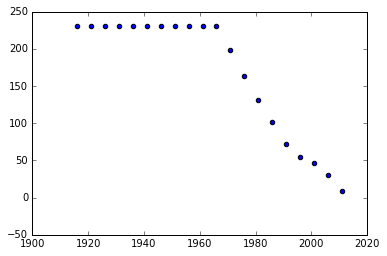

In [35]:
plt.scatter(current_year - thresholds, rcs)

In [38]:
metric ='recentcite_10'

In [39]:
c = create_metric_column(G, metric, year=2016)

# h index

In [105]:
v = G.vs[798]
h = 2

In [239]:

def get_vertex_recent_hindex(v):
    """
    Naive implementation: SUPER SLOW (no 100% sure I did this right)
    TODO: implement this in a less dumb way
    """
    MAXITER = 1e4
    
    # neighbors of v
    citations = v.neighbors(mode='IN')

    h = 1
    keep_going = True
    
    if len(citations) == 0:
        return 0
    else:
        i = 0
        while keep_going and i <= MAXITER:
            i += 1
            # if v has at least h citations
            if len(citations) > h: 
                # who each have at least h citation
                if len([c for c in citations if len(c.neighbors(mode="IN")) >= h]) <= h:
                    keep_going = False
            else:
                keep_going = False
        return h

In [240]:
def get_hindex(G):
    return [get_vertex_recent_hindex(v) for v in G.vs]

In [241]:
%time hindx = get_hindex(G)

CPU times: user 1h 35min 35s, sys: 2min 23s, total: 1h 37min 59s
Wall time: 1h 37min 3s


# CiteRank

In [12]:
n = len(G.vs)

p = .85
reset = [1.0/n] * n
pp = G.personalized_pagerank(damping=p, reset=reset)

pr = G.pagerank()

In [35]:
p = .85
current_year = 2016
half_life = 5.0

def get_CiteRank(G, half_life, p=.85):
    
    half_life = float(half_life)
    
    # years of each case
    years = np.array(G.vs['year'])
    current_year = max(years)

    # compute exponentially decaying probabilities
    ages = current_year - years
    exp_weights = 2 ** (- ages/half_life)
    probs = exp_weights / exp_weights.sum()

    return G.personalized_pagerank(damping=p, reset=probs)

In [19]:
cr = get_CiteRank(G, 5)
pr = G.pagerank()

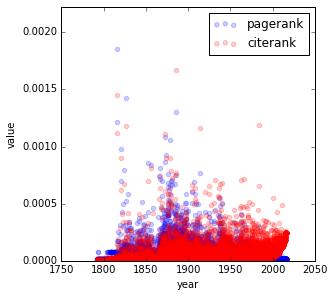

In [43]:
plt.figure(figsize=[10, 10])
n = len(G.vs)
years = G.vs['year']

# plot pr vs ta_pr
plt.subplot(2,2,1)
plt.scatter(years, pr, 
            color='blue',
            alpha=.2,
            label='pagerank')

plt.scatter(years, cr,
            alpha=.2,
            color='red',
            label='citerank')
plt.ylim([0, 1.2 * max(max(cr), max(pr))])
plt.legend(loc='upper right')
plt.xlabel('year')
plt.ylabel('value')


# CiteRankPoly